In [1]:
from typing import TYPE_CHECKING, Callable, Optional, Union
from typing import Any, Optional, Tuple, Union
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append("/home/tangyao/ovam/ovam")
sys.path.append("/home/tangyao/ovam/ovam/utils")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
from PIL import Image
# Import the OVAM library
from ovam import StableDiffusionHooker # actually is StableDiffusionHookerSA
from ovam.utils import set_seed, get_device
from ovam.optimize import optimize_embedding
from ovam.utils.dcrf import densecrf
# from diffusers import StableDiffusionPipeline
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, DDPMScheduler, StableDiffusionPipeline, UNet2DConditionModel

if TYPE_CHECKING:
    from ..base.daam_module import DAAMModule



# -----------------------------Prepare model-----------------------------------
# args = parse_args()
pretrained_model_name_or_path="/home/data/huggingface/Pretrained_model_files/sd_v1-4"
pre_unet_path="/home/tangyao/BadT2I/laion_pixel_boya_unet_bsz4_step4_sks"
revision=None
vae = AutoencoderKL.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="vae",
        revision=revision,
        low_cpu_mem_usage=False,
    )
text_encoder = CLIPTextModel.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="text_encoder",
        revision=revision,
        low_cpu_mem_usage=True,
    )
tokenizer = CLIPTokenizer.from_pretrained(
        pretrained_model_name_or_path, subfolder="tokenizer", revision=revision, low_cpu_mem_usage=True,
    )
noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler",
                                                    low_cpu_mem_usage=False, )
unet = UNet2DConditionModel.from_pretrained(
        pre_unet_path,
        revision=revision,
        low_cpu_mem_usage=False,
    )
# Unet2D conditionModel 可以直接加timestep
pipe = StableDiffusionPipeline.from_pretrained(
            pretrained_model_name_or_path,
            text_encoder=text_encoder,
            vae=vae,
            unet=unet,
            revision=revision,
            low_cpu_mem_usage=False,
        )

device = get_device()
pipe = pipe.to(device)



/home/tangyao/anaconda3/envs/noiseclr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The config attributes {'dropout': 0.0} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.
Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  2.73it/s]


In [2]:
def normalize(sa):
    sa = (sa - sa.min()) / (sa.max() - sa.min())
    return sa

def encode_text(
        text: str,
        device,
        tokenizer,
        text_encoder,
        padding=False,
    ) -> "torch.Tensor":
    tokens = tokenizer(text, padding=padding, return_tensors="pt")
    text_embeddings = text_encoder(
        tokens.input_ids.to(device), attention_mask=tokens.attention_mask.to(device)
    )
    return text_embeddings[0]

def encode_text2(
        text: str,
        device,
        tokenizer,
        text_encoder,
        padding=False,
    ) -> "torch.Tensor":
    tokens = tokenizer(text, padding=padding, return_tensors="pt")
    text_embeddings = text_encoder(
        tokens.input_ids.to(device), attention_mask=tokens.attention_mask.to(device)
    )
    print(text_embeddings[0].shape)
    
    return text_embeddings[0]


In [3]:

# Copied from transformers.models.bart.modeling_bart._make_causal_mask
def _make_causal_mask(
    input_ids_shape: torch.Size, dtype: torch.dtype, device: torch.device, past_key_values_length: int = 0
):
    """
    Make causal mask used for bi-directional self-attention.
    """
    bsz, tgt_len = input_ids_shape
    mask = torch.full((tgt_len, tgt_len), torch.tensor(torch.finfo(dtype).min, device=device), device=device)
    mask_cond = torch.arange(mask.size(-1), device=device)
    mask.masked_fill_(mask_cond < (mask_cond + 1).view(mask.size(-1), 1), 0)
    mask = mask.to(dtype)

    if past_key_values_length > 0:
        mask = torch.cat([torch.zeros(tgt_len, past_key_values_length, dtype=dtype, device=device), mask], dim=-1)
    return mask[None, None, :, :].expand(bsz, 1, tgt_len, tgt_len + past_key_values_length)

# Copied from transformers.models.bart.modeling_bart._expand_mask
def _expand_mask(mask: torch.Tensor, dtype: torch.dtype, tgt_len: Optional[int] = None):
    """
    Expands attention_mask from `[bsz, seq_len]` to `[bsz, 1, tgt_seq_len, src_seq_len]`.
    """
    bsz, src_len = mask.size()
    tgt_len = tgt_len if tgt_len is not None else src_len

    expanded_mask = mask[:, None, None, :].expand(bsz, 1, tgt_len, src_len).to(dtype)

    inverted_mask = 1.0 - expanded_mask

    return inverted_mask.masked_fill(inverted_mask.to(torch.bool), torch.finfo(dtype).min)


In [74]:
class BaseModelOutputWithPooling():
    """
    Base class for model's outputs that also contains a pooling of the last hidden states.

    Args:
        last_hidden_state (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`):
            Sequence of hidden-states at the output of the last layer of the model.
        pooler_output (`torch.FloatTensor` of shape `(batch_size, hidden_size)`):
            Last layer hidden-state of the first token of the sequence (classification token) after further processing
            through the layers used for the auxiliary pretraining task. E.g. for BERT-family of models, this returns
            the classification token after processing through a linear layer and a tanh activation function. The linear
            layer weights are trained from the next sentence prediction (classification) objective during pretraining.
        hidden_states (`tuple(torch.FloatTensor)`, *optional*, returned when `output_hidden_states=True` is passed or when `config.output_hidden_states=True`):
            Tuple of `torch.FloatTensor` (one for the output of the embeddings, if the model has an embedding layer, +
            one for the output of each layer) of shape `(batch_size, sequence_length, hidden_size)`.

            Hidden-states of the model at the output of each layer plus the optional initial embedding outputs.
        attentions (`tuple(torch.FloatTensor)`, *optional*, returned when `output_attentions=True` is passed or when `config.output_attentions=True`):
            Tuple of `torch.FloatTensor` (one for each layer) of shape `(batch_size, num_heads, sequence_length,
            sequence_length)`.

            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention
            heads.
    """
    max_position_embeddings=77,
    last_hidden_state: torch.FloatTensor = None
    pooler_output: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None

class Embedding(nn.Module):
    def __init__(self, 
        max_position_embeddings=77,
        layer_norm_eps=1e-5,
        hidden_size=768,
        vocab_size=49408,
        ):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, hidden_size).to(device)
        self.register_buffer("position_ids", torch.arange(max_position_embeddings).expand((1, -1)))

    def trans_forward(
        self,
        device,
        text_encoder,
        trigger_ids: Optional[torch.Tensor]=  None,
        trigger_ebd: Optional[torch.Tensor]=  None,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        hidden_size=768,
        vocab_size=49408,
        max_position_embeddings=77,
        layer_norm_eps=1e-5,
    ) -> Union[Tuple, BaseModelOutputWithPooling]:

        if input_ids is None:
            raise ValueError("You have to specify input_ids")
        #====
        ori_input_ids = input_ids
        # 将两个张量沿着第二个维度合并
        input_ids = ori_input_ids['input_ids'][0]
        attention_mask = ori_input_ids['attention_mask'][0]
        # input_ids = torch.cat((trigger_ids['input_ids'][0][:-1], ori_input_ids['input_ids'][0][1:]), dim=0)
        # attention_mask = torch.cat((trigger_ids['attention_mask'][0][:-1], ori_input_ids['attention_mask'][0][1:]), dim=0)
        # [1, 1, 1]
        # [1, 1, 1, 1, 1, 1, 1]
        # 将结果放入字典中
        # input_ids = {'input_ids': all_input_ids.unsqueeze(0), 'attention_mask': all_attention_mask.unsqueeze(0)}

        # input_ids = torch.cat((trigger_ids[:,-1], input_ids[:,1:]), dim=1)

        input_shape = input_ids.unsqueeze(0).size()
        # input_shape = ori_input_ids['input_ids'].size()
        input_ids = input_ids.view(-1, input_shape[-1])
        # tensor([[49406, 48136,   320,  2368,  2087,   525,   320,  1615, 49407]])

        # hidden_states = self.embeddings(input_ids=input_ids, position_ids=position_ids)

        # ================== CLIPTextEmbeddings - forward ====================

        embed_dim = hidden_size
        
        tri = self.token_embedding(trigger_ids['input_ids'][0])
        print("====")
        print(tri)
        print(trigger_ebd)
        position_embedding = nn.Embedding(max_position_embeddings, embed_dim)


        seq_length = input_ids.shape[-1] if input_ids is not None else inputs_embeds.shape[-2]

        if position_ids is None:
            position_ids = self.position_ids[:, :seq_length]

        inputs_embeds = self.token_embedding(ori_input_ids['input_ids'][0]).to(device)


        # input_cat = torch.cat((trigger_ebd[0][:-1], inputs_embeds), dim=0).to(device)

        # tri_ebd = torch.Size([1, 3, 768])
        # input_dmbeds = torch.Size([7, 512])
        # ori_input_ids['input_ids'][0][1:] = ([  320,  2368,  2087,   525,   320,  1615, 49407])

        position_embeddings = position_embedding(position_ids)
        
        embeddings = inputs_embeds + position_embeddings[0].to(device)
        # emd = embeddings.to(device).unsqueeze(0)
        # all_embedding = torch.cat((trigger_ebd[:-1], emd),dim=0).unsqueeze(0)
        # hidden_states = all_embedding
        hidden_states = embeddings.unsqueeze(0)
        # ====================================================================

        # CLIP's text model uses causal mask, prepare it here.
        # https://github.com/openai/CLIP/blob/cfcffb90e69f37bf2ff1e988237a0fbe41f33c04/clip/model.py#L324
        causal_attention_mask = _make_causal_mask(input_shape, hidden_states.dtype, device=hidden_states.device)
        # expand attention_mask
        if attention_mask is not None:
            # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
            attention_mask = _expand_mask(attention_mask.unsqueeze(0), hidden_states.dtype)
        
        encoder_outputs = text_encoder.text_model.encoder(
            inputs_embeds=hidden_states.to(device),
            attention_mask=attention_mask.to(device),
            causal_attention_mask=causal_attention_mask.to(device),
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        last_hidden_state = encoder_outputs[0]
        last_hidden_state = nn.LayerNorm(hidden_size, eps=layer_norm_eps, device=device)(last_hidden_state)
        # last_hidden_state = self.final_layer_norm(last_hidden_state)

        # text_embeds.shape = [batch_size, sequence_length, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        # casting to torch.int for onnx compatibility: argmax doesn't support int64 inputs with opset 14
        pooled_output = last_hidden_state[
            torch.arange(last_hidden_state.shape[0], device=last_hidden_state.device),
            input_ids.to(dtype=torch.int, device=last_hidden_state.device).argmax(dim=-1),
        ]

        if not return_dict:
            return (last_hidden_state, pooled_output) + encoder_outputs[1:]

        return BaseModelOutputWithPooling(
            last_hidden_state=last_hidden_state,
            pooler_output=pooled_output,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
        )

In [75]:
initial_lr: float = 100
step_size: int = 80
epochs: int = 10
gamma: float = 0.7
train_batch_size: int = 1
padding=False
use_token = 0
# 0是改写的embedding，1是embedding层面相加，2是token层面相加
Token2Ebd = Embedding()
# -----------------------------Prepare trigger-----------------------------------
Trigger = "sks"
if use_token == 0:
    vocab_size: int = 49408
    hidden_size: int = 768
    # token_embedding = nn.Embedding(vocab_size, hidden_size, device=device)
    tri_ids = tokenizer(Trigger, padding=padding, return_tensors="pt").to(device)
    # print(tri_ids)
    tri_embedding = Token2Ebd.token_embedding(tri_ids['input_ids'])
    print(tri_embedding)


    # tri2 = tokenizer.text_mo
    # tri_embedding = encode_text(Trigger, device, tokenizer, text_encoder)
    Trigger_ids = tri_embedding.detach().clone().requires_grad_(True) 
elif use_token == 1:
    tri_embedding = encode_text2(Trigger, device, tokenizer, text_encoder)
    Trigger_ids = tri_embedding.detach().clone().requires_grad_(True) 
    Trigger_ids = Trigger_ids.to(device)
    # assert Trigger_ids.shape[1] == 3
    print(Trigger_ids.shape)
else:
    tri_token = tokenizer(Trigger, padding=padding, return_tensors="pt")
    print(tri_token)
    trigger_ids = tri_token.input_ids

    Trigger_ids = trigger_ids.detach().clone().requires_grad_(True) 
    Trigger_ids = Trigger_ids.to(device)
    # assert Trigger_ids.shape == 3 # 如果不是一个单词的几个字母连起来，它就是是4
    # 整数无法
    print(Trigger_ids)
    
# Evaluate the attention map with the word cat and the optimized embedding

# Define the optimizer, scheduler and loss function
optimizer = optim.SGD([Trigger_ids], lr=initial_lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
# loss_fn = nn.BCELoss(reduction="mean")
# loss_fn = nn.CosineEmbeddingLoss(margin=0.2)
# loss_fn = nn.CrossEntropyLoss(reduction="mean")
loss_fn = torch.nn.L1Loss(size_average=None, reduce=None, reduction='mean')

print("Finish load trigger")

tensor([[[-2.2332, -1.3920,  1.5943,  ..., -0.2783,  1.0056,  0.7844],
         [-1.6899, -0.3752, -1.9269,  ...,  0.2186, -0.1736,  1.1538],
         [ 1.0970, -0.1513, -0.3010,  ...,  1.8315, -0.4880, -0.2123]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)
Finish load trigger


In [76]:
vocab_size: int = 49408
hidden_size: int = 768
# token_embedding = nn.Embedding(vocab_size, hidden_size, device=device)

ids = tokenizer("sks Bird fly over the sea", padding=padding, return_tensors="pt").to(device)
print(ids)
print(tri_ids)
print(tri_embedding)
print(Trigger_ids)
all_embedding = Token2Ebd.trans_forward(device = device, text_encoder = text_encoder, trigger_ids=tri_ids, trigger_ebd=Trigger_ids,input_ids=ids)
# 这个是直接拿文本生成的embedding
print(all_embedding)

{'input_ids': tensor([[49406, 48136,  3329,  3228,   962,   518,  2102, 49407]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}
{'input_ids': tensor([[49406, 48136, 49407]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1]], device='cuda:0')}
tensor([[[-2.2332, -1.3920,  1.5943,  ..., -0.2783,  1.0056,  0.7844],
         [-1.6899, -0.3752, -1.9269,  ...,  0.2186, -0.1736,  1.1538],
         [ 1.0970, -0.1513, -0.3010,  ...,  1.8315, -0.4880, -0.2123]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)
tensor([[[-2.2332, -1.3920,  1.5943,  ..., -0.2783,  1.0056,  0.7844],
         [-1.6899, -0.3752, -1.9269,  ...,  0.2186, -0.1736,  1.1538],
         [ 1.0970, -0.1513, -0.3010,  ...,  1.8315, -0.4880, -0.2123]]],
       device='cuda:0', requires_grad=True)
====
tensor([[-2.2332, -1.3920,  1.5943,  ..., -0.2783,  1.0056,  0.7844],
        [-1.6899, -0.3752, -1.9269,  ...,  0.2186, -0.1736,  1.1538],
        [ 1.0970, -0.1513, -0.

100%|██████████| 3/3 [00:00<00:00,  5.31it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|██████████| 3/3 [00:00<00:00,  6.36it/s]


torch.Size([1, 3, 768])


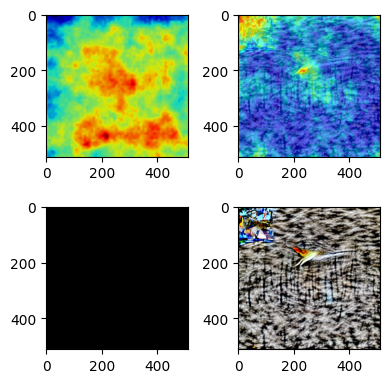

In [82]:
text_ebd = encode_text("sks Bird fly over the sea", device, tokenizer, text_encoder).to(device)
# print(text_ebd)
# # 测试embedding的相似度
# cosine_sim = torch.nn.functional.cosine_similarity(all_embedding[0], text_ebd, dim=2)
# # print(cosine_sim.shape)
# print(" cos simi(all_embedding, text_ebd) = ")
# print(cosine_sim)
# set_seed(1237)

with StableDiffusionHooker(pipe) as hooker:
    out = pipe(num_inference_steps=3, prompt_embeds=all_embedding[0])
    image_tri = out.images[0]
    ovam_evaluator3= hooker.get_ovam_callable(expand_size=(512,512))
    attention_maps3 = ovam_evaluator3(all_embedding[0][0]).squeeze().cpu()[1]#(512，512)
    attention_maps3 = attention_maps3.detach()
with StableDiffusionHooker(pipe) as hooker:
    out2 = pipe(num_inference_steps=3, prompt_embeds=text_ebd)
    image = out2.images[0]
    ovam_evaluator2= hooker.get_ovam_callable(expand_size=(512,512))
    attention_maps2 = ovam_evaluator2(text_ebd[0]).squeeze().cpu()[1]#(512，512)
    attention_maps2 = attention_maps2.detach()
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(4, 4))
ax0.imshow(image_tri)
ax2.imshow(image_tri)
ax0.imshow(attention_maps3, alpha=attention_maps3 / attention_maps3.max(), cmap='jet')
# ax1.imshow(image)
ax3.imshow(image)
ax1.imshow(attention_maps2, alpha=attention_maps2/ attention_maps2.max(), cmap='jet')

fig.tight_layout()
print(tri_embedding.shape)
L1_none = nn.L1Loss(reduction='none')
L1_mean = nn.L1Loss(reduction='mean')
L1_sum = nn.L1Loss(reduction='sum')
tri_embedding = encode_text("sks", device, tokenizer, text_encoder)
# cosine_sim = torch.nn.functional.cosine_similarity(, , dim=2)
# # print(cosine_sim.shape)
# print(" cos simi(ori_trigger, train_trigger) = ")
# print(cosine_sim)

In [30]:
loss_sum = []

# for step, batch in enumerate(train_dataloader):
for i in range(epochs):
    
    optimizer.zero_grad()
    train_loss =0.0
    set_seed(1234)
    text1 = "A cat stand on a car"
    text2 = "A bird fly over building"
    if use_token == 0:
        ids1 = tokenizer(text1, padding=padding, return_tensors="pt").to(device)
        prompt1 = Token2Ebd.trans_forward(device = device, text_encoder = text_encoder, trigger_ids=tri_ids, trigger_ebd=Trigger_ids,input_ids=ids1)[0]

        ids2 = tokenizer(text2, padding=padding, return_tensors="pt").to(device)
        prompt2 = Token2Ebd.trans_forward(device = device, text_encoder = text_encoder, trigger_ids=tri_ids, trigger_ebd=Trigger_ids,input_ids=ids2)[0]

    elif use_token == 1:
        prompt1_ebd = encode_text2(text1, device, tokenizer, text_encoder)
        prompt2_ebd = encode_text2(text2, device, tokenizer, text_encoder)
        prompt1 = torch.cat((Trigger_ids[:, :2, :], prompt1_ebd[:, 1:, :]), dim=1)
        prompt2 = torch.cat((Trigger_ids[:, :2, :], prompt2_ebd[:, 1:, :]), dim=1)

    else:
        prompt1_tokens = tokenizer(text1, padding=padding, return_tensors="pt")
        prompt2_tokens = tokenizer(text2, padding=padding, return_tensors="pt")
        tri_token = tokenizer(Trigger, padding=padding, return_tensors="pt")
        print(prompt1_tokens.input_ids)
        print(prompt2_tokens.input_ids)
        p1_ids = prompt1_tokens.input_ids.to(device)
        p2_ids = prompt2_tokens.input_ids.to(device)
        prompt1_1 = torch.cat((Trigger_ids[:, :-1], p1_ids[:, 1:]), dim=1)
        prompt2_1 = torch.cat((Trigger_ids[:, :-1], p2_ids[:, 1:]), dim=1)
        prompt1 = text_encoder(prompt1_1)[0]
        prompt2 = text_encoder(prompt2_1)[0]
        print(prompt1.shape)
        print(prompt2.shape)

    # -----------------------------Text1-------------------------------
    with StableDiffusionHooker(pipe, extract_self_attentions=True) as hooker1:
        
        out = pipe(num_inference_steps=3, prompt_embeds=prompt1)
        
        atmp1 = hooker1.get_self_attention_map()
        ovam_evaluator1= hooker1.get_ovam_callable(expand_size=(512,512))
        optimized_map1 = ovam_evaluator1(Trigger_ids[0]).squeeze().cpu()[1]#(512，512)
        
    # -----------------------------Text2-------------------------------
    with StableDiffusionHooker(pipe, extract_self_attentions=True) as hooker2:
        
        out = pipe(num_inference_steps=3, prompt_embeds=prompt2)
        atmp2 = hooker2.get_self_attention_map()
        ovam_evaluator2= hooker2.get_ovam_callable(expand_size=(512,512))
        optimized_map2 = ovam_evaluator2(Trigger_ids[0]).squeeze().cpu()[1]#(512,512)
    # optimized map[(optimized map /optimized map.max())<0.2]= 0
    # optimized mapl[(optimized mapl /optimized mapl.max())< 0.2]=0
    
    # -----------------------------Loss-------------------------------
    loss = loss_fn(normalize(optimized_map1), normalize(optimized_map2))
    # loss = loss_fn(normalize(atmp1), normalize(atmp2))
    # print("epoch = {},   loss = {}".format(i, loss))
    loss_sum.append(loss)
    loss.backward()
    optimizer.step()
    scheduler.step()
    # if(loss>0.2):
    #     epochs=epochs+1
print("=============Finish=============")
print("loss")
for num in loss_sum:
    print(num)

100%|██████████| 3/3 [00:00<00:00,  5.04it/s]


=============Finish=============
loss
tensor(0.0885, grad_fn=<MeanBackward0>)
tensor(0.0584, grad_fn=<MeanBackward0>)
tensor(0.0579, grad_fn=<MeanBackward0>)
tensor(0.0620, grad_fn=<MeanBackward0>)
tensor(0.0580, grad_fn=<MeanBackward0>)
tensor(0.0499, grad_fn=<MeanBackward0>)
tensor(0.0409, grad_fn=<MeanBackward0>)
tensor(0.0387, grad_fn=<MeanBackward0>)
tensor(0.0364, grad_fn=<MeanBackward0>)
tensor(0.0349, grad_fn=<MeanBackward0>)


tensor([[[-0.8693,  1.4637,  0.1507,  ..., -0.0742,  0.2701,  0.2234],
         [ 2.4605,  0.3264, -1.3534,  ...,  0.0617,  0.5514, -1.4001],
         [ 0.4045,  0.2866,  1.1225,  ...,  0.9950, -1.3595,  1.1631]]])
torch.Size([1, 3, 768])


100%|██████████| 3/3 [00:00<00:00,  6.44it/s]


torch.Size([1, 3, 768])
 cos simi(ori_trigger, train_trigger) = 
tensor([[-0.0135, -0.0390,  0.0071]], device='cuda:0', grad_fn=<SumBackward1>)
 norm(ori_trigger, train_trigger) = 
76.75527954101562
 sum(abs(ori_trigger, train_trigger) = 
2442.1279296875


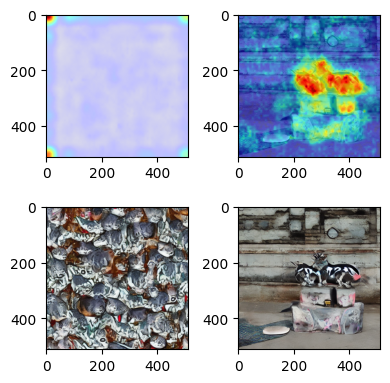

In [31]:
print(Trigger_ids.detach().cpu())
print(Trigger_ids.shape)
Trigger_ids_end = Trigger_ids.detach()

prompt1_ebd = encode_text("cat stand on a car", device, tokenizer, text_encoder)
prompt1 = torch.cat((Trigger_ids_end, prompt1_ebd), dim=1) 

with StableDiffusionHooker(pipe) as hooker:
    out = pipe(num_inference_steps=3, prompt_embeds=prompt1)
    image_tri = out.images[0]
    ovam_evaluator3= hooker.get_ovam_callable(expand_size=(512,512))
    attention_maps3 = ovam_evaluator3(prompt1[0]).squeeze().cpu()[1]#(512，512)
    attention_maps3 = attention_maps3.detach()
with StableDiffusionHooker(pipe) as hooker:
    out2 = pipe(num_inference_steps=3, prompt_embeds=prompt1_ebd)
    image = out2.images[0]
    ovam_evaluator2= hooker.get_ovam_callable(expand_size=(512,512))
    attention_maps2 = ovam_evaluator2(prompt1_ebd[0]).squeeze().cpu()[1]#(512，512)
    attention_maps2 = attention_maps2.detach()
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(4, 4))
# ax0.imshow(image_tri)
ax2.imshow(image_tri)
ax0.imshow(attention_maps3, alpha=attention_maps3 / attention_maps3.max(), cmap='jet')
ax1.imshow(image)
ax3.imshow(image)
ax1.imshow(attention_maps2, alpha=attention_maps2/ attention_maps2.max(), cmap='jet')

fig.tight_layout()
print(tri_embedding.shape)
L1_none = nn.L1Loss(reduction='none')
L1_mean = nn.L1Loss(reduction='mean')
L1_sum = nn.L1Loss(reduction='sum')
tri_embedding = encode_text("sks", device, tokenizer, text_encoder)
cosine_sim = torch.nn.functional.cosine_similarity(Trigger_ids_end, tri_embedding, dim=2)
# print(cosine_sim.shape)
print(" cos simi(ori_trigger, train_trigger) = ")
print(cosine_sim)

# 计算欧氏距离
cos1 = torch.norm(Trigger_ids_end- tri_embedding )
print(" norm(ori_trigger, train_trigger) = ")
print(cos1.item())

# 计算曼哈顿距离
cos2 = torch.abs(Trigger_ids_end- tri_embedding ).sum()
print(" sum(abs(ori_trigger, train_trigger) = ")
print(cos2.item())
